In [1]:
import numpy as np
import numpy.linalg as nplin
import scipy.linalg as sclin
import matplotlib.pyplot as plt

In [38]:
theta_list = np.linspace(0, 4*np.pi, 1000)
beta_list = np.array([-2, -1, -0.5, 0, 0.01, 0.1, 0.5, 1, 2])
spike_list = np.array([1, 2, 3, 4, 6, 10, 15, 30])

In [65]:
def theta_model(theta, beta):
    return 1-np.cos(theta)+np.dot(beta, 1+np.cos(theta))

def spike_rep(theta, definition = 1):
   return (1-np.cos(theta))**definition

def beta_cycle(beta):
    return np.cos(beta*2*np.pi)/(2*np.pi)

def beta_const(beta):
   return 0

def dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_model):
  theta = np.array([theta_0])
  beta = np.array([beta_0])
  for i in range(int(time_stop/time_step)):
    Vtheta = theta_model(theta[i], beta[i])
    Vbeta = beta_model(beta[i])
    theta = np.concatenate((theta, theta[i:i+1]+Vtheta*time_step))
    beta = np.concatenate((beta, beta[i:i+1]+Vbeta*time_step))
  return theta, beta

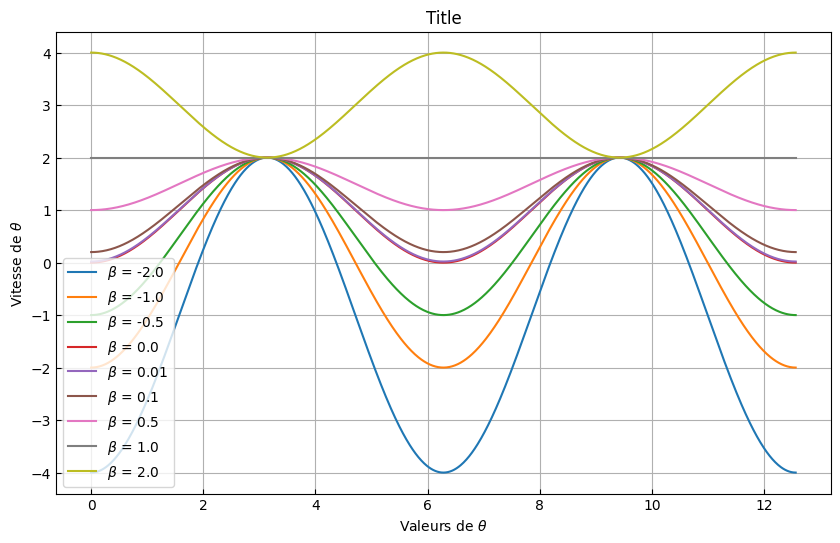

In [41]:
plt.figure(figsize=(10, 6))

for beta in beta_list:
  plt.plot(theta_list, theta_model(theta_list, beta), label=fr'$\beta$ = {beta}')#+f' {beta}'
plt.xlabel(r"Valeurs de $\theta$")
plt.ylabel(r"Vitesse de $\theta$")
plt.title("Title")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

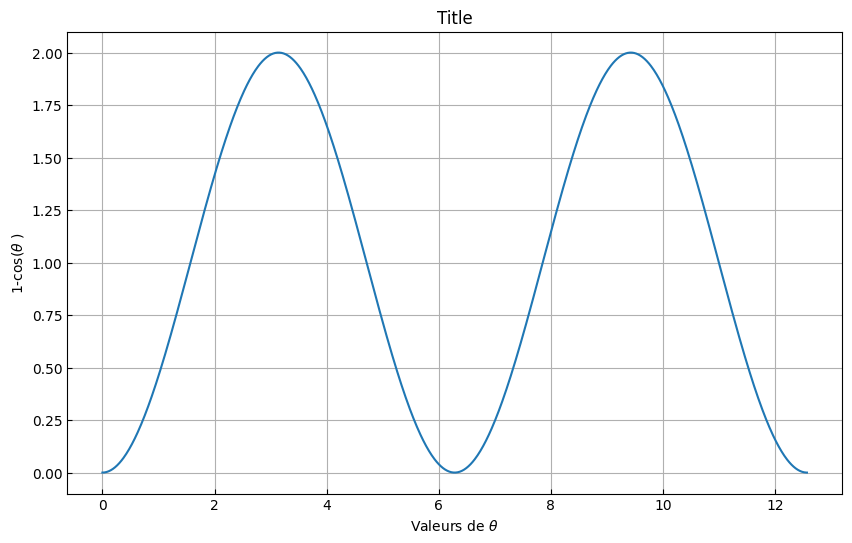

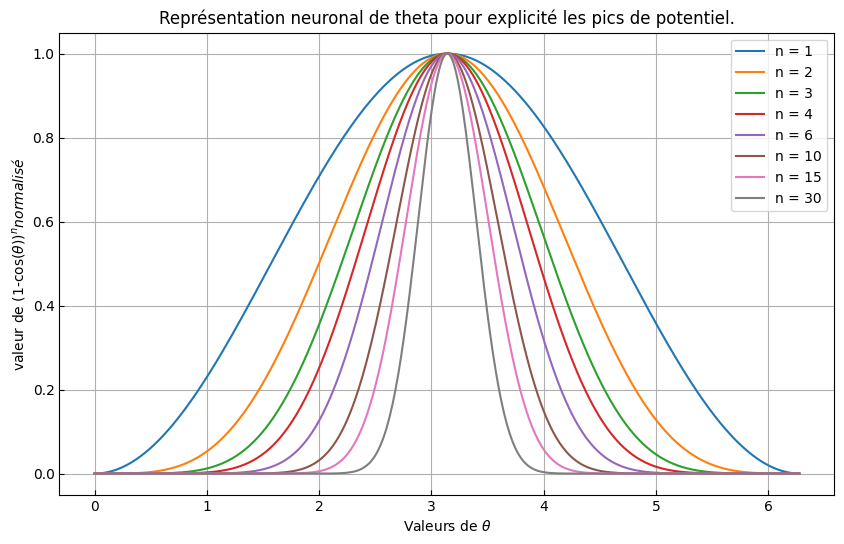

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(theta_list, spike_rep(theta_list))
plt.xlabel(r"Valeurs de $\theta$")
plt.ylabel(r"1-cos($\theta$ )")
plt.title("Title")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
half_theta = theta_list[:int(len(theta_list)/2)]
for i in spike_list:
  ydata = spike_rep(half_theta, i)
  plt.plot(half_theta, ydata/2**i, label=f'n = {i}')
plt.xlabel(r"Valeurs de $\theta$")
plt.ylabel(r"valeur de (1-cos$(\theta ))^n normalisé$")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel à différent degrés.")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
theta_0 = 0
beta_0 = 0.1

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)

theta = [0.00000000e+00 2.00000000e-03 4.00001800e-03 ... 6.29227294e+00
 6.29427331e+00 6.29627387e+00]
(1-cos($\theta$)$)^10$ = [0.00000000e+00 9.99996667e-61 1.04865639e-54 ... 1.40729927e-47
 7.52357248e-46 2.07574739e-44]


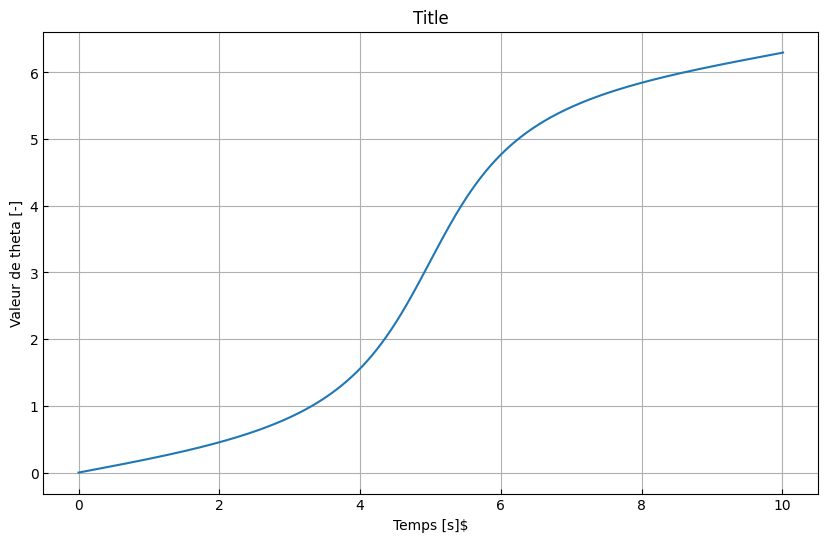

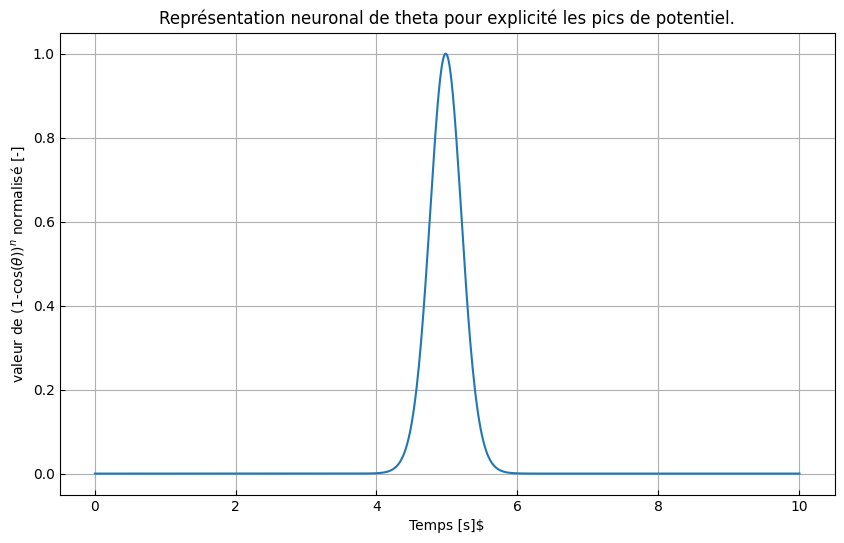

In [56]:
theta, beta = dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
print(f'theta = {theta}')
print(fr'(1-cos($\theta$)$)^10$ = {(1-np.cos(theta))**10/2**10}')

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"Valeur de theta [-]")
plt.title("Title")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, (1-np.cos(theta))**10/2**10)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"valeur de (1-cos$(\theta ))^n$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

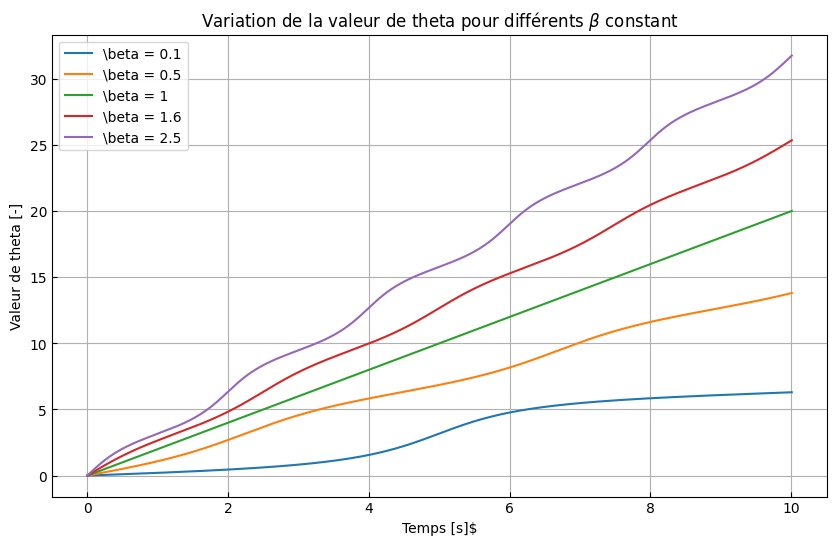

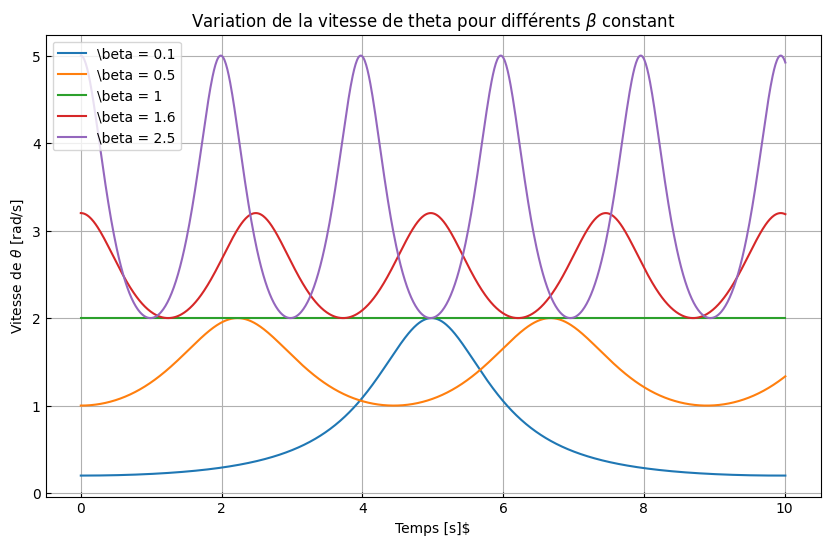

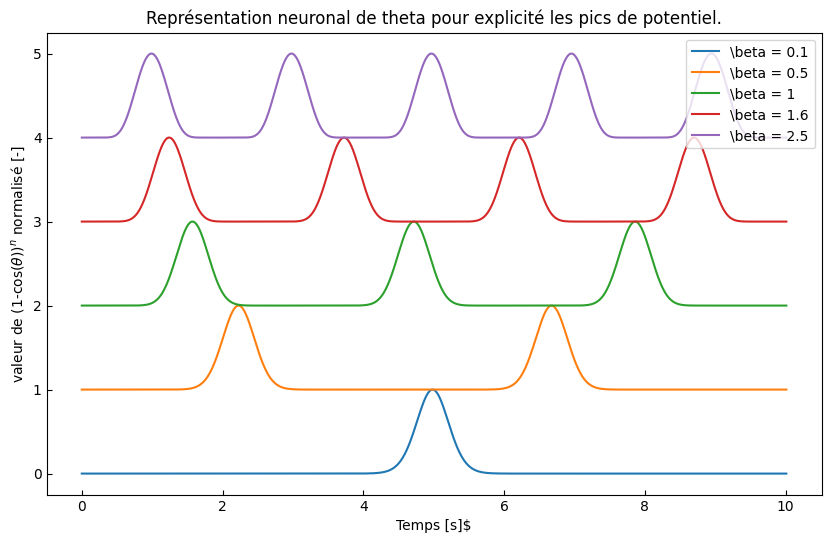

In [68]:
beta_0_list = [0.1, 0.5, 1, 1.6, 2.5]
theta_0=0
plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta, label = fr'\beta = {beta_0}')
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"Valeur de theta [-]")
plt.title(r"Variation de la valeur de theta pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta_model(theta, beta_0), label = fr'\beta = {beta_0}')
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de theta pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for i, beta_0 in enumerate(beta_0_list):
    theta, beta = dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, i+(1-np.cos(theta))**10/2**10, label = fr'\beta = {beta_0}')
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"valeur de (1-cos$(\theta ))^n$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.legend()
plt.show()